# BubbleAI HDF5 quickstart

This notebook shows how to work with the packaged BubbleAI microscope datasets stored in data/BubbleAI/h5. Each file bundles the cropped PNG frames and the accompanying Excel metadata tables.


In [ ]:

from pathlib import Path
from io import StringIO
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

DATA_DIR = Path('../data/BubbleAI/h5').resolve()
print(f'Data directory: {DATA_DIR}')
if not DATA_DIR.exists():
    raise FileNotFoundError('Expected data/BubbleAI/h5 to exist.')


Data directory: C:\Users\aisci\OneDrive\Desktop\DTMicroscope-main\data\BubbleAI\h5


In [3]:

h5_files = sorted(DATA_DIR.glob('*.h5'))
if not h5_files:
    raise RuntimeError('No .h5 files found in data/BubbleAI/h5')

for path in h5_files:
    print(path.name)


0_25_wt_coco_b_0_75wt_coco_glucoside.h5
0_25_wt_coco_betain_0_75wt_capryl_glucoside.h5
0_5_wt_coco_betain_0_5wt_capryl_glucoside.h5
0_5_wt_coco_betain_0_5wt_coco_glucoside.h5
1_wt_capryl_glucoside.h5
1wt_coco_betaine_bd.h5
1wt_coco_glucoside.h5


In [4]:

def describe_file(path: Path):
    with h5py.File(path, 'r') as h5:
        meta_keys = list(h5['metadata'].keys()) if 'metadata' in h5 else []
        return {
            'file': path.name,
            'mixture': h5.attrs.get('mixture_name', path.stem),
            'images': int(h5.attrs.get('image_count', 0)),
            'metadata_keys': meta_keys,
        }

def load_image(path: Path, idx: int = 0) -> np.ndarray:
    with h5py.File(path, 'r') as h5:
        return np.array(h5['images/data'][idx])

def load_metadata(path: Path, key: str) -> pd.DataFrame:
    with h5py.File(path, 'r') as h5:
        raw = h5[f'metadata/{key}'][()]
    text = raw.decode('utf-8') if isinstance(raw, (bytes, bytearray)) else str(raw)
    return pd.read_csv(StringIO(text))


In [5]:

summaries = [describe_file(p) for p in h5_files]
pd.DataFrame(summaries)


,file,mixture,images,metadata_keys
0,0_25_wt_coco_b_0_75wt_coco_glucoside.h5,0.25 wt% coco- B & 0.75wt % coco-Glucoside,427,[0_25_wt_coco_betain_0_75wt_coco_glucoside_bd]
1,0_25_wt_coco_betain_0_75wt_capryl_glucoside.h5,0.25 wt% coco-betain & 0.75wt % Capryl-Glucoside,419,[0_25_wt_coco_betain_0_75wt_capryl_glucoside_w...
2,0_5_wt_coco_betain_0_5wt_capryl_glucoside.h5,0.5 wt% coco-betain & 0.5wt % Capryl-glucoside,359,"[0_5_wt_coco_betain_0_5wt_capryl_glucoside_bd,..."
3,0_5_wt_coco_betain_0_5wt_coco_glucoside.h5,0.5 wt% coco-betain & 0.5wt % coco-glucoside,299,[0_5_wt_coco_betain_0_5wt_coco_glucoside_with_...
4,1_wt_capryl_glucoside.h5,1 wt% Capryl-Glucoside,0,"[1_wt_capryl_glucoside_with_structures_bd, 1_w..."
5,1wt_coco_betaine_bd.h5,1wt% Coco Betaine BD,0,[]
6,1wt_coco_glucoside.h5,1wt% Coco Glucoside,0,"[1wt_coco_glucoside_with_structure_bd, 1wt_coc..."


Using 0_25_wt_coco_b_0_75wt_coco_glucoside.h5 (0.25 wt% coco- B & 0.75wt % coco-Glucoside)
Image stack shape: (1080, 1319, 3)


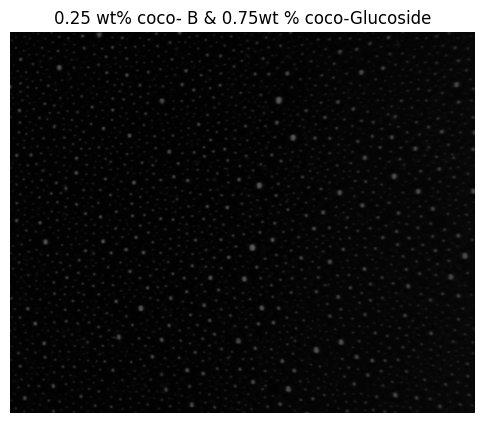

In [6]:

image_file = next((p for p in h5_files if describe_file(p)['images'] > 0), None)
if image_file is None:
    print('No images stored in any file.')
else:
    image_info = describe_file(image_file)
    sample = load_image(image_file, idx=0)
    print(f"Using {image_file.name} ({image_info['mixture']})")
    print('Image stack shape:', sample.shape)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(sample)
    ax.set_title(image_info['mixture'])
    ax.axis('off')


In [7]:

if image_file is not None:
    image_info = describe_file(image_file)
    if image_info['metadata_keys']:
        first_key = image_info['metadata_keys'][0]
        df = load_metadata(image_file, first_key)
        print(f'Metadata table: {first_key} -> {df.shape[0]} rows')
        display(df.head())
    else:
        print('This file has no metadata entries.')
else:
    print('No metadata loaded because there are no image files.')


Metadata table: 0_25_wt_coco_betain_0_75wt_coco_glucoside_bd -> 477 rows


,t [s],BC [mm⁻²],M̅B̅A̅ [µm²],SD M̅B̅A̅ [µm²],Ravg [µm],Rrms [µm],R21 [µm],R32 [µm],v,w
0,445.57,89.924,11120,5925,58,59,61,65,2,4
1,450.57,86.258,11593,6286,59,61,63,67,2,3
2,455.57,86.049,11621,6813,59,61,63,68,2,5
3,460.57,85.899,11642,6733,59,61,63,68,2,5
4,465.57,86.367,11578,6480,59,61,63,67,2,5
